<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/11-seq-2-seq/01_sequence_to_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Sequence-tosequence

In particular, we will develop an algorithm known as sequence-tosequence
(Seq2Seq for short) that can perform machine translation. As the name implies,
this is an approach for getting neural networks to take one sequence as input and
produce a different sequence as the output. 

Seq2Seq has been used to get computers to
perform symbolic calculus, summarize long documents, and even translate from one
language to another. I’ll show you step by step how we can translate from English to
French.

You
could hypothetically get an RNN to do anything Seq2Seq could do, but it would be
difficult to get it to work. One problem is that an RNN alone implies that the output
sequence is the same length as the input, which is rarely true. Seq2Seq decouples the
input and output into two separate stages and parts and thus works much better.

At a high level, the Seq2Seq algorithm trains a
denoising autoencoder over sequences rather than static images. 

You can think of the
original English as the noisy input and French as the clean output, and we ask the
Seq2Seq model to learn how to remove the noise.

We have an
encoder and decoder to convert inputs to outputs just like a denoising autoencoder;
the difference is that a Seq2Seq model works over sequences instead of images or fully
connected inputs.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/11-seq-2-seq/images/seq2seq.png?raw=1)

Here we have some original input sequence $X = x_1, x_2, ..., x_T$ , and the goal is to
output a new sequence $Y = y_1, y_2, ..., y_{\hat T}$ . These sequences do not have to be the
same. $x_j \neq y_j$ , and they can even be different lengths so T $6 \neq \hat T$ is also possible.

The secret to getting a Seq2Seq model working well is adding an attention mechanism.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/11-seq-2-seq/images/seq2seq_attn.png?raw=1)

Notice that the last
hidden state from the encoder, hT , becomes the initial hidden state of the decoder, but
we haven’t indicted what the inputs to the decoder are at each time step.

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

from idlmam import train_network, Flatten, weight_reset, View, set_seed
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, ApplyAttention, getMaskByFill

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##English-French dataset

In [6]:
# let’s quickly load small English-French dataset
all_data = []
response = urlopen("https://download.pytorch.org/tutorial/data.zip")
zipfile = ZipFile(BytesIO(response.read()))

for line in zipfile.open("data/eng-fra.txt").readlines():
  line = line.decode("utf-8").lower()   # lower case only please
  line = re.sub(r"[-.!?]+", r" ", line) # no puntuation
  source_lang, target_lang = line.split("\t")[0: 2]
  all_data.append((source_lang.strip(), target_lang.strip())) # (english, french)

In [7]:
for i in range(10):
  print(all_data[i])

('go', 'va')
('run', 'cours')
('run', 'courez')
('wow', 'ça alors')
('fire', 'au feu')
('help', "à l'aide")
('jump', 'saute')
('stop', 'ça suffit')
('stop', 'stop')
('stop', 'arrête toi')


In [8]:
all_data[:10]

[('go', 'va'),
 ('run', 'cours'),
 ('run', 'courez'),
 ('wow', 'ça alors'),
 ('fire', 'au feu'),
 ('help', "à l'aide"),
 ('jump', 'saute'),
 ('stop', 'ça suffit'),
 ('stop', 'stop'),
 ('stop', 'arrête toi')]

In [9]:
# To make training faster, let’s limit ourselves to sentences that contain six or fewer words.
short_subset = []
MAX_LEN = 6

for (s, t) in all_data:
  if max(len(s.split(" ")), len(t.split(" "))) <= MAX_LEN:
    short_subset.append((s, t))
print(f"Using {len(short_subset)} / {len(all_data)}")

Using 66251 / 135842


In [ ]:
class TranslationDataset(Dataset):
  """
  Creates a modified version of a dataset where some number of samples are taken, 
  and the true label is the largest label sampled. When used with MNIST the labels 
  correspond to their values (e.g., digit "6" has label 6)
  """
  def __init__(self, dataset, toSample=3):
    """
    dataset: the dataset to sample from
    toSample: the number of items from the dataset to sample
    """
    self.dataset = dataset
    self.toSample = toSample 

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # Randomly select n=self.toSample items from the dataset
    selected = np.random.randint(0, len(self.dataset), size=self.toSample)
    
    # Stack the n items of shape (B, *) shape into (B, n, *)
    x_new = torch.stack([self.dataset[i][0] for i in selected])
    # Label is the maximum label
    y_new = max([self.dataset[i][1] for i in selected])
    
    # Return (data, label) pair!
    return x_new, y_new

In [ ]:
B = 128
epochs= 10

largest_train = LargestDigit(mnist_train)
largest_test = LargestDigit(mnist_test)

train_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
test_loader = DataLoader(largest_train, batch_size=B)

True Label is = 8


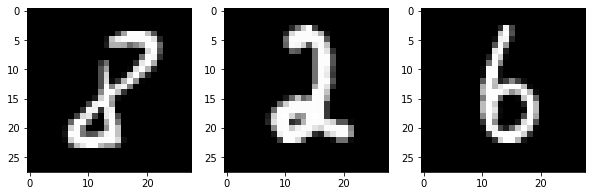

In [ ]:
# Want a consistent dataset split
set_seed(34)

x, y = largest_train[0]

f, axarr = plt.subplots(1, 3, figsize=(10, 10))
for i in range(3):
  axarr[i].imshow(x[i, 0, :].numpy(), cmap="gray", vmin=0, vmax=1)
print(f"True Label is = {y}")